In [1]:
%%bash
if [ -d "data" ]
then
    echo "Data already downloaded"
else
    kaggle competitions download -c golemcompetition
    mkdir "data"
    unzip golemcompetition.zip -d "data"
    rm golemcompetition.zip
    echo "Data downloaded"
fi

Data already downloaded


In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

In [3]:
# Disable false positive warning
pd.options.mode.chained_assignment = None

## Load data

In [4]:
train_df = pd.read_csv(f'data/train.csv')
test_df = pd.read_csv(f'data/test.csv')

## Prepare labels

In [5]:
train_y = train_df['target'].to_numpy()

In [6]:
print(train_y)
print(train_y.shape)

[0 1 0 ... 0 0 1]
(240000,)


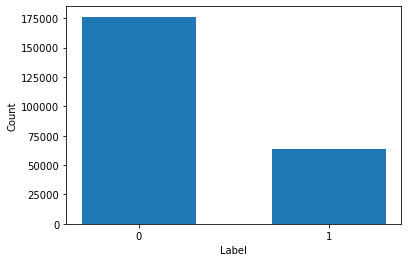

In [7]:
labels, counts = np.unique(train_y, return_counts=True)

plt.figure()
plt.bar(labels, counts, width=0.6)
plt.xlabel('Label')
plt.xticks(labels)
plt.ylabel('Count')
plt.show()

## Preprocess data

### Utilities

In [8]:
class Vectorizer:
    
    def __init__(self, cat_min_count=40):
        self.cat_cols = None
        self.cat_rares = {}
        self.cat_min_count = cat_min_count
        self.cat_ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

        self.cont_cols = None
    
    def fit(self, df):
        df = df.copy()

        # Categorical
        ## Find categorical columns
        self.cat_cols = [col for col in df if col.startswith('cat')]
        ## Find rare categories
        for col in self.cat_cols:
            rares = [
                cat for cat, cnt in df[col].value_counts().items()
                if cnt < self.cat_min_count]
            if len(rares) > 1:
                self.cat_rares[col] = rares
        ## Replace rare categories
        cat_df = df[self.cat_cols]
        for col, rares in self.cat_rares.items():
            cat_df[col].replace({v: 'other' for v in rares}, inplace=True)
        ## Fit one-hot encoder
        self.cat_ohe.fit(cat_df.to_numpy())

        # Continuous
        ## Find continous columns
        self.cont_cols = [col for col in df if col.startswith('cont')]
    
    def transform(self, df):
        df = df.copy()

        # Categorical
        cat_df = df[self.cat_cols]
        ## Replace rare categories
        for col, rares in self.cat_rares.items():
            cat_df[col].replace({v: 'other' for v in rares}, inplace=True)
        cat_data = self.cat_ohe.transform(cat_df.to_numpy())

        # Continuous
        cont_df = df[self.cont_cols]
        cont_data = cont_df.to_numpy()

        return np.concatenate((cat_data, cont_data), axis=1)

### Training data

In [9]:
vectorizer = Vectorizer()
vectorizer.fit(train_df)

In [10]:
train_x = vectorizer.transform(train_df)

In [11]:
print(train_x)
print(train_x.shape)

[[1.         0.         0.         ... 0.72613346 0.26004987 0.5289969 ]
 [1.         0.         0.         ... 0.4872016  0.77056101 0.65087419]
 [1.         0.         0.         ... 0.41307522 0.28207711 0.3348734 ]
 ...
 [1.         0.         0.         ... 0.65121281 0.69128416 0.66986683]
 [0.         1.         0.         ... 0.29815198 0.55114124 0.41114094]
 [1.         0.         0.         ... 0.56588133 0.52964258 0.30763682]]
(240000, 517)


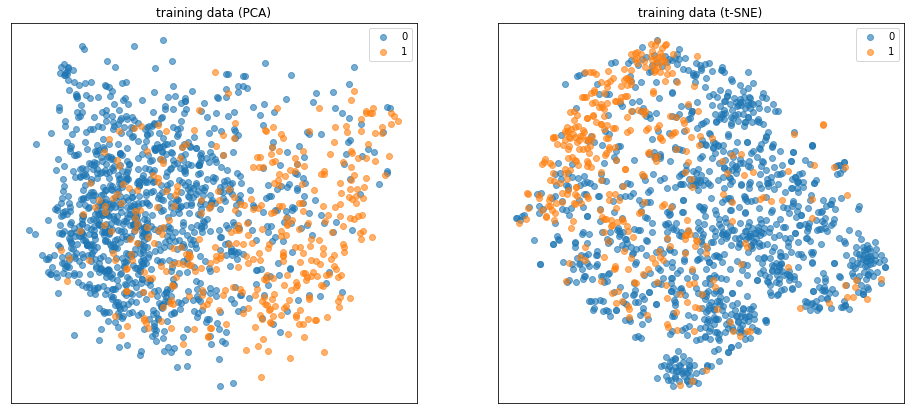

In [12]:
algorithms = {
    'PCA': PCA(n_components=2),
    't-SNE': TSNE(n_components=2)}

plt.figure(figsize=(16, 7))
for i, (name, algorithm) in enumerate(algorithms.items()):
    x = algorithm.fit_transform(train_x[:1500])
    y = train_y[:1500]

    plt.subplot(1, 2, i + 1)

    points = x[y == 0]
    plt.scatter(points[:, 0], points[:, 1], alpha=0.6, label='0')
    points = x[y == 1]
    plt.scatter(points[:, 0], points[:, 1], alpha=0.6, label='1')

    plt.title(f'training data ({name})')
    plt.legend()
    plt.xticks([])
    plt.yticks([])
plt.show()

### Test data

In [13]:
test_x = vectorizer.transform(test_df)

In [14]:
print(test_x)
print(test_x.shape)

[[0.         1.         0.         ... 0.38833366 0.4285618  0.46420165]
 [1.         0.         0.         ... 0.44242636 0.46735214 0.30619257]
 [1.         0.         0.         ... 0.38232406 0.63764778 0.46795552]
 ...
 [1.         0.         0.         ... 0.25202408 0.26464742 0.30393237]
 [1.         0.         0.         ... 0.73220791 0.47053269 0.31421989]
 [1.         0.         0.         ... 0.36348862 0.39708014 0.37002727]]
(60000, 517)


## Random forest

### Cross validation

In [15]:
n_estimators_ = [192, 224, 256, 288, 320, 352, 384, 416, 448, 480]
max_depth_ = [16, 32, 48, 64, 80, 96, 112, 128, 144, 160]

scores = np.zeros((len(n_estimators_), len(max_depth_)))

In [16]:
start = time.time()

print('n_estimators\tmax_depth\taccuracy')
for yi, ne in enumerate(n_estimators_):
    for xi, md in enumerate(max_depth_):
        print(f'{ne:>12}\t{md:>9}\t', end='')
        clf = RandomForestClassifier(n_estimators=ne, max_depth=md, n_jobs=-1)
        scores[yi][xi] = np.mean(cross_val_score(clf, train_x, train_y, cv=5))
        print(f'{scores[yi][xi]:.6f}')
print('----------------------------------------')

hours, seconds = divmod(time.time() - start, 3600)
minutes, seconds = divmod(seconds, 60)
print(f'Finished in {int(hours)}h {int(minutes)}m {int(seconds)}s')

n_estimators	max_depth	accuracy
         192	       16	0.844742
         192	       32	0.847850
         192	       48	0.847721
         192	       64	0.848354
         192	       80	0.847975
         192	       96	0.847925
         192	      112	0.848062
         192	      128	0.848208
         192	      144	0.848008
         192	      160	0.848096
         224	       16	0.844621
         224	       32	0.847508
         224	       48	0.847912
         224	       64	0.848200
         224	       80	0.848092
         224	       96	0.848125
         224	      112	0.848229
         224	      128	0.848054
         224	      144	0.848304
         224	      160	0.848162
         256	       16	0.844663
         256	       32	0.848158
         256	       48	0.848179
         256	       64	0.848221
         256	       80	0.848054
         256	       96	0.848279
         256	      112	0.847892
         256	      128	0.848229
         256	      144	0.848096
         256	      160	0.848079
        

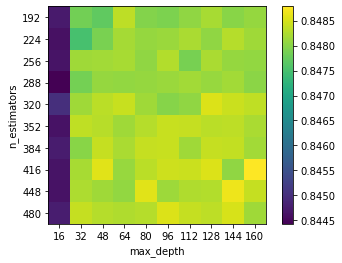

In [17]:
n_estimators_ = [str(v) for v in n_estimators_]
max_depth_ = [str(v) for v in max_depth_]

plt.figure()
plt.imshow(scores)
plt.xlabel('max_depth')
plt.xticks(ticks=range(len(max_depth_)), labels=max_depth_)
plt.ylabel('n_estimators')
plt.yticks(ticks=range(len(n_estimators_)), labels=n_estimators_)
plt.colorbar()
plt.show()

### Solution

In [18]:
# Train classifier
clf = RandomForestClassifier(
    n_estimators=352, max_depth=80, n_jobs=-1, verbose=1)
clf.fit(train_x, train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 352 out of 352 | elapsed:  1.3min finished


RandomForestClassifier(max_depth=80, n_estimators=352, n_jobs=-1, verbose=1)

In [19]:
# Predict
test_y_pred = clf.predict(test_x)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done 352 out of 352 | elapsed:    1.9s finished


In [20]:
# Save submission
with open('submission.csv', 'w') as fh:
    fh.write('id,Category\n')
    for i, l in zip(test_df['id'], test_y_pred):
        fh.write(f'{i},{l}\n')